In [1]:
import PROMOCS
from PROMOCS import *

In [2]:
molecules_list = [set_dative_bonds(m) for m in load_smiles('smiles.smi')] #implement dative bonds for metal complexes

In [3]:
#fingerprint calculation
ECFP_df = generate_ECFP(molecules_list, radius = 6, nbit = 2048)
ECFP_df

,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,ECFP8,ECFP9,ECFP10,...,ECFP2039,ECFP2040,ECFP2041,ECFP2042,ECFP2043,ECFP2044,ECFP2045,ECFP2046,ECFP2047,ECFP2048
0,1,0,1,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
1,1,0,1,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,1,1,1,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
138,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
139,1,0,1,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
140,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [4]:
#load descriptors
alva_df = pd.read_csv("alva.csv",delimiter=";")
LUMO_df = pd.read_csv("LUMO.csv",delimiter=";")
target = pd.read_csv("E.csv",delimiter=";")

#eliminate Alvadesc descriptors with errors
for column in alva_df.columns:
    alva_df[column] = pd.to_numeric(alva_df[column], errors='coerce')
    
alva_df = alva_df.fillna(np.nan)
alva_df = alva_df.dropna(axis=1)
alva_df = alva_df.select_dtypes(include='int')

#replace invalid characters for some Ml models
alva_df.rename(columns=lambda x: x.replace('[', '('), inplace=True)
alva_df.rename(columns=lambda x: x.replace(']', ')'), inplace=True)

#perform OHE
alva_df_OHE = OHE(alva_df)

#create a complete dataframe of all descriptors with the target to be predicted
data = pd.concat([ECFP_df, alva_df_OHE, LUMO_df, target], axis=1)

#scaling the values of LUMO and H_L so that they have the same range as the fingerprints 
norm = preprocessing.MinMaxScaler()
data['LUMO'] = norm.fit_transform(data[['LUMO']])    
data['L_H'] = norm.fit_transform(data[['L_H']])
data

,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,ECFP8,ECFP9,ECFP10,...,s34_phSize_7,s34_phSize_8,s34_phSize_9,s34_phSize_10,s34_phSize_11,s34_phSize_13,s34_phSize_15,LUMO,L_H,E
0,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.352734,0.834712,-0.743
1,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.276953,0.420072,-0.784
2,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.210417,0.579435,-0.711
3,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.246745,0.567214,-0.736
4,1,0,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0.299089,0.641155,-0.699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.611328,1.000000,0.040
138,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.607812,0.984199,0.075
139,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.870312,0.891248,-0.289
140,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.696745,0.872608,-0.014


In [5]:
print(f"The target has a mean of {statistics.mean(data['E']):.2f} V and a standard deviation of {statistics.stdev(data['E']):.2f} V.")

The target has a mean of -0.21 V and a standard deviation of 0.46 V.


In [6]:
X = data.drop("E", axis=1)
corr_features = detect_high_corr(X, 0.9) #detect high correlated features
print(f" {len(set(corr_features))} correlated features founded on a total of {len(data.columns)} features.")

Research in progress: 99% 2224 correlated features founded on a total of 5514 features.


In [7]:
X.drop(labels=corr_features, axis=1, inplace=True)

In [8]:
feature_importances = np.zeros(X.shape[1])

In [9]:
#model benchmark on dataset A
y = data.E
models = [RandomForestRegressor(random_state=0),
          GradientBoostingRegressor(random_state=0),
          xgb.XGBRegressor(random_state=0),
          ExtraTreeRegressor(random_state=0),
          DecisionTreeRegressor(random_state=0),
         ]
df_results = benchmark(X, y, models)
df_results

,mse,rmse,mae,r2
Model,,,,
RandomForestRegressor,0.06,0.24,0.17,0.73
GradientBoostingRegressor,0.05,0.22,0.16,0.77
XGBRegressor,0.04,0.21,0.14,0.80
ExtraTreeRegressor,0.09,0.30,0.20,0.56
DecisionTreeRegressor,0.09,0.29,0.19,0.59


In [10]:
X_sel_RFR = select_features(models[0], X, y)
X_sel_GBR = select_features(models[1], X, y)
X_sel_XGBR = select_features(models[2], X, y)
X_sel_ETR = select_features(models[3], X, y)
X_sel_DTR = select_features(models[4], X, y)

In [11]:
print(f"Features selected by models are:")
print(f"{len(X_sel_RFR.columns)} for {type(models[0]).__name__}")
print(f"{len(X_sel_GBR.columns)} for {type(models[1]).__name__}")
print(f"{len(X_sel_XGBR.columns)} for {type(models[2]).__name__}")
print(f"{len(X_sel_ETR.columns)} for {type(models[3]).__name__}")
print(f"{len(X_sel_DTR.columns)} for {type(models[4]).__name__}")

Features selected by models are:
238 for RandomForestRegressor
110 for GradientBoostingRegressor
87 for XGBRegressor
44 for ExtraTreeRegressor
41 for DecisionTreeRegressor


In [12]:
#model benchmark on dataset B
model_names = ['RandomForestRegressor',
               'GradientBoostingRegressor',
               'XGBRegressor',
               'ExtraTreeRegressor',
               'DecisionTreeRegressor']

results_list = []
feat_sel_list = []

for model, X_sel in zip(models, [X_sel_RFR, X_sel_GBR, X_sel_XGBR, X_sel_ETR, X_sel_DTR]):
    df_results, feat_imp_df, y_pred_list = evaluate_model(X_sel, y, model)
    results_list.append(df_results)
    feat_sel_list.append(len(X_sel.columns))

df_results = pd.concat(results_list)

df_results['Model'] = model_names
df_results.set_index('Model', inplace=True)

df_results['feat'] = feat_sel_list

df_results = df_results.round(3)
df_results

,mse,rmse,mae,r2,feat
Model,,,,,
RandomForestRegressor,0.048,0.219,0.148,0.769,238
GradientBoostingRegressor,0.031,0.175,0.120,0.853,110
XGBRegressor,0.029,0.170,0.109,0.862,87
ExtraTreeRegressor,0.037,0.193,0.106,0.821,44
DecisionTreeRegressor,0.042,0.205,0.120,0.799,41


C:\Users\Wks\AppData\Local\Temp\ipykernel_6848\2034854718.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(feat_imp_df_ETR['Feature'], rotation=90)


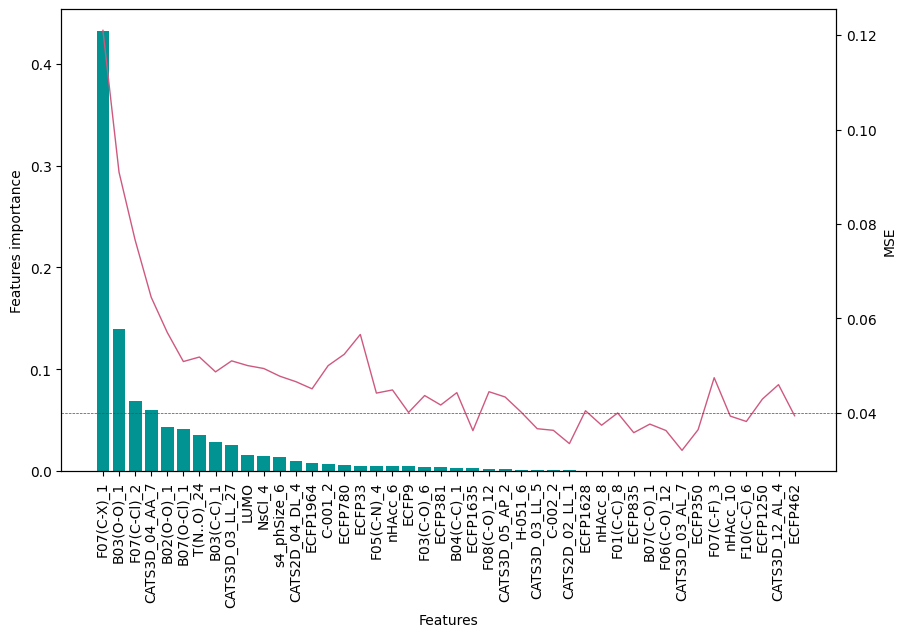

In [13]:
#Recursive Features Elimination
df_results_ETR, feat_imp_df_ETR, y_pred_list_ETR = evaluate_model(X_sel_ETR, y, models[3])

RFE_results = RFE(feat_imp_df_ETR.Feature, X_sel_ETR, y, models[3])

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(feat_imp_df_ETR['Feature'], feat_imp_df_ETR['Importance'], color="#009392")
ax1.set_xlabel('Features')
ax1.set_ylabel('Features importance')

ax2 = ax1.twinx()
ax2.plot(feat_imp_df_ETR['Feature'], RFE_results, color='#CF597E', linewidth=1)
ax2.set_ylabel('MSE')

ax2.axhline(y=RFE_results[20].round(2), color='green', linestyle='--', linewidth=0.5)

ax1.set_xticklabels(feat_imp_df_ETR['Feature'], rotation=90)

plt.show()

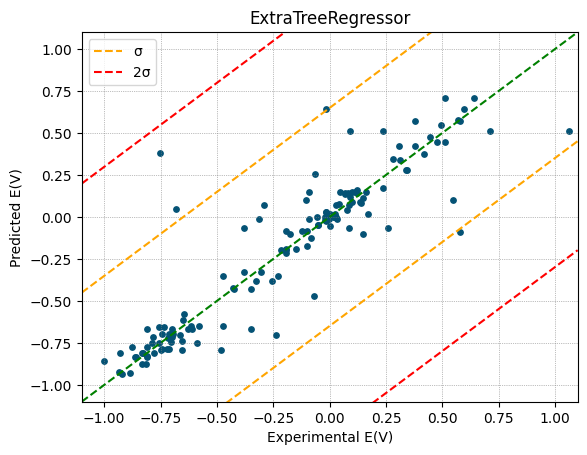

In [14]:
plot_scatter(y, y_pred_list_ETR, models[3], ref=1.1)

In [15]:
#final evaluation with and without outliers detected
best_params_ = {'max_depth': 19,
                'min_samples_leaf': 1,
                'min_samples_split': 4}

model_opt = ExtraTreeRegressor(random_state=0, **best_params_)

df_results_ETR_opt, feat_imp_df_ETR_opt, y_pred_list_ETR_opt = evaluate_model(X[feat_imp_df_ETR.Feature.head(21)],
                                                                              y,
                                                                              model_opt)

df_no_outlier = X[feat_imp_df_ETR['Feature'].head(20)].copy()
df_no_outlier['E'] = y

index_out = [105, 85, 114, 43, 36, 39, 116, 15]
df_no_outlier = df_no_outlier.drop(index_out).reset_index(drop=True)

y_no_outlier = df_no_outlier['E']
X_no_outlier = df_no_outlier.drop(columns=['E'])

df_results_ETR_opt_no_out, feat_imp_df_ETR_opt_no_out, y_pred_list_ETR_opt_no_out = evaluate_model(X_no_outlier,
                                                                              y_no_outlier,
                                                                              model_opt)

index_list = ["with_outliers", "without_outliers"]
df_results_ETR_tot = pd.concat([df_results_ETR_opt,df_results_ETR_opt_no_out])
df_results_ETR_tot["index"] = index_list
df_results_ETR_tot.set_index('index', inplace=True)
df_results_ETR_tot = df_results_ETR_tot.round(3)
df_results_ETR_tot

,mse,rmse,mae,r2
index,,,,
with_outliers,0.038,0.194,0.113,0.820
without_outliers,0.016,0.126,0.088,0.918


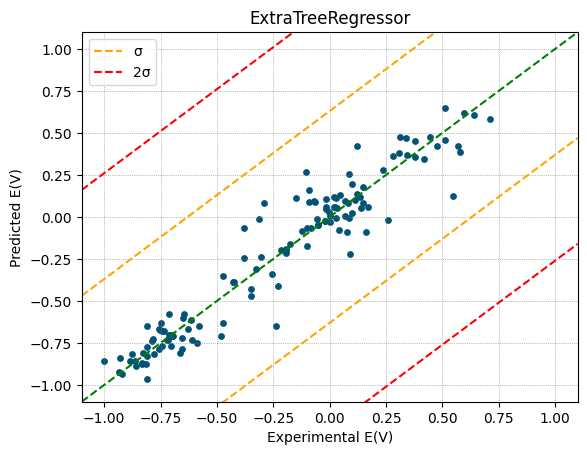

In [16]:
plot_scatter(y_no_outlier, y_pred_list_ETR_opt_no_out, models[3], ref=1.1)

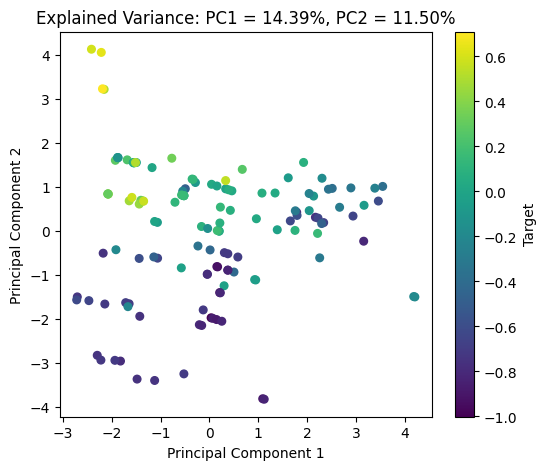

In [17]:
pca_components = plot2D(X_no_outlier, hue_data=y_no_outlier, palette='viridis', figsize=(6,5), dot = 30)

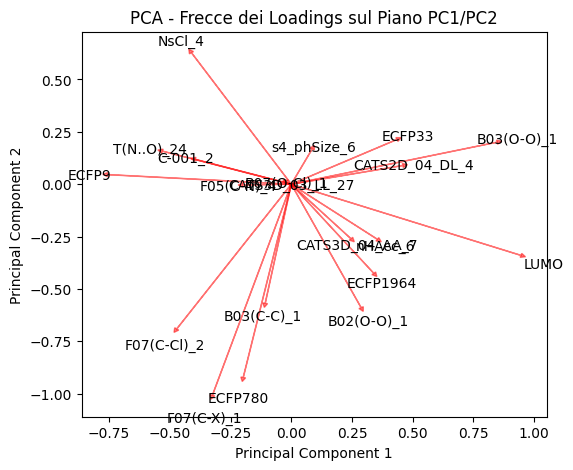

In [18]:
plot_loadings(pca_components, X_no_outlier, figsize=(6,5))

In [19]:
#performance without LUMO descriptor
X_no_LUMO = X_no_outlier.drop("LUMO",axis=1)

df_results_ETR_no_LUMO, feat_imp_df_ETR_opt_no_LUMO, y_pred_list_ETR_opt_no_LUMO = evaluate_model(X_no_LUMO,
                                                                              y_no_outlier,
                                                                              model_opt)

df_results_ETR_no_LUMO = df_results_ETR_no_LUMO.round(3)
df_results_ETR_no_LUMO

,mse,rmse,mae,r2
0,0.018,0.134,0.096,0.908


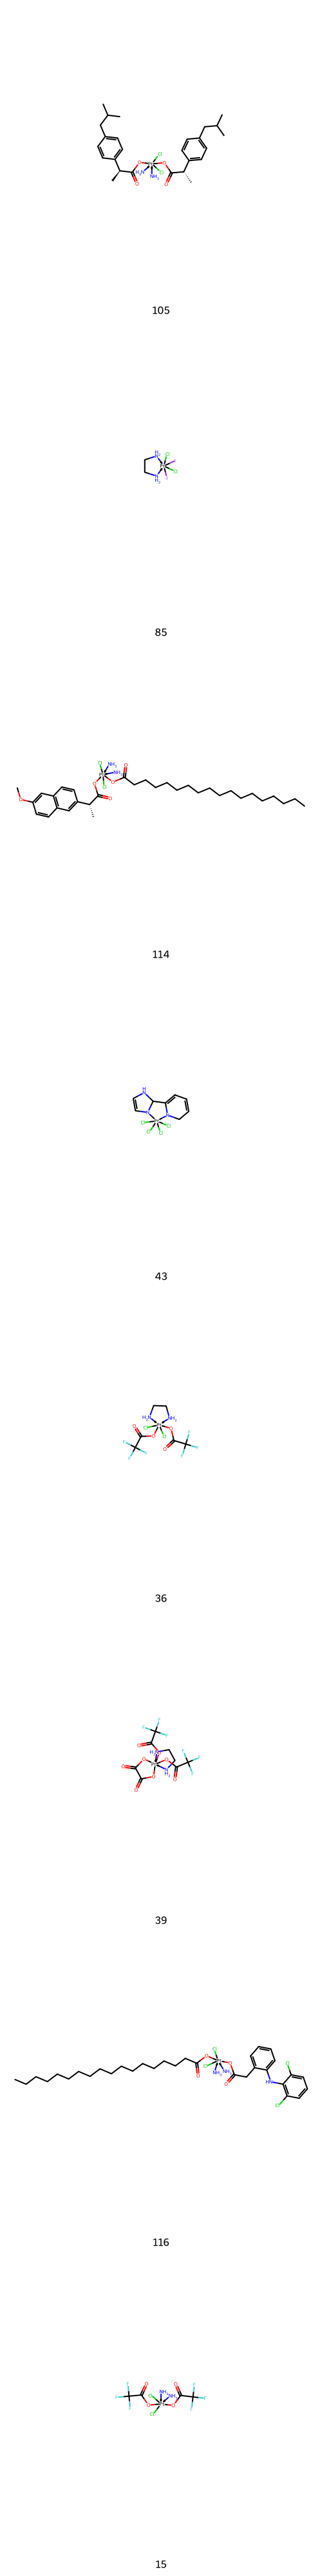

In [20]:
#Outliers removed structures
molecules_list_new = [105, 85, 114, 43, 36, 39, 116, 15]

subms = [molecules_list[idx] for idx in molecules_list_new]

img = Draw.MolsToGridImage(subms, molsPerRow=1,
                           subImgSize=(500, 500),
                           legends=[str(idx) for idx in molecules_list_new])
img

In [21]:
df_results_ETR_opt_no_out

,mse,rmse,mae,r2
0,0.015946,0.126279,0.088393,0.918492
